In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit
import numpy as np
from functools import partial
from math import factorial

In [32]:
def line(x, a, b):
    return a + x * b

def power_law(x, a, b):
    return a * np.power(x, b)

def power_law_fit(x, y):
    x_log = np.log10(x)
    y_log = np.log10(y)
    popt, pcov = curve_fit(line, x_log, y_log, p0=[0.1, 1.0])
    # print('COV', pcov)
    print('sigma', np.sqrt(np.diagonal(pcov)))
    a=np.power(10, popt[0])
    b=popt[1]
    fitted_power_law = partial(power_law, a=a, b=b)
    return a, b, fitted_power_law

Before NaN filter: 7
After NaN filter: 7
sigma [0.02499146 0.00402774]
0.04229357120859401 1.0008503593362597
sigma [0.0184158  0.00296797]
0.047259194157285876 1.0020621659856366
sigma [0.00916457 0.001477  ]
0.056622162222940545 1.0033437446035862
sigma [0.02797015 0.0045078 ]
0.06346612040587939 1.0020892588455328
sigma [0.01856724 0.00299238]
0.08824964860510254 0.9989715549692714
sigma [0.02395218 0.00386024]
0.08104330779530532 1.002724479957834
sigma [0.01687033 0.0027189 ]
0.10423950763461122 1.0023855414984015


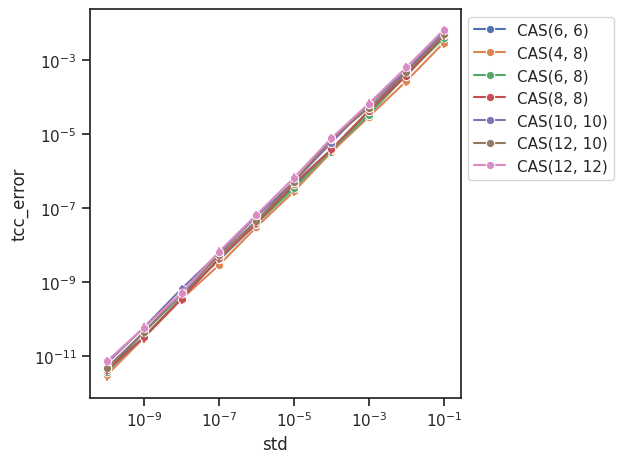

In [33]:
def analyze_noise_data(row):
    df = row.df
    df['tcc_error'] += 1e-15
    nalpha, nbeta, ncas = row.nalpha, row.nbeta, row.nact
    cas = f"CAS({nalpha+nbeta}, {ncas})"
    sns.set_theme(style="ticks")
    ax = sns.lineplot(data=df, x="std", y="tcc_error", markers=True, err_style="bars", marker="o", label=cas)
    ax.set_yscale("log")
    ax.set_xscale("log")
    stds = np.unique(df['std'])
    # # TODO: fit using mean over realizations
    errors_mean = df.groupby("std").mean().tcc_error.values
    a, b, fun = power_law_fit(stds, errors_mean)
    print(a, b)
    return a, b


# data = pd.read_hdf("noise_data_formaldehyde.h5", key="df")
# data = pd.read_hdf("noise_data_n2_real.h5", key="df")

# data = pd.read_hdf("noise_data_acetaldehyde.h5", key="df")

data = pd.read_hdf("noise_data_eccc.h5", key="df")
print("Before NaN filter:", len(data.index))
data = data[data['df'].notna()]
print("After NaN filter:", len(data.index))
# print(data)

data['ncas'] = data.nact
data['nocc'] = data.nalpha + data.nbeta
data['nvirt'] = 2 * data.ncas - data.nocc
data['nvirta'] = data.nact - data.nalpha
data['nvirtb'] = data.nact - data.nbeta

from tailoredcc.amplitudes import number_overlaps_eccc
data['noverlaps'] = number_overlaps_eccc(data.nact, data.nalpha, data.nbeta)


data['cas'] = data.apply(lambda row: f"({row.nalpha + row.nbeta}, {row.nact})", axis=1)
data[['a', 'b']] = data.apply(analyze_noise_data, axis=1, result_type='expand')

plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()

In [43]:
data[['cas', 'noverlaps']].to_latex("cas_eccc_info_sigma.tex", columns=['cas', 'noverlaps'], index=False)

In [34]:
merged_df = pd.DataFrame()
for _, row in data.iterrows():
    inner_df = row['df']
    inner_df['noverlaps'] = row['noverlaps']
    merged_df = pd.concat([merged_df, inner_df])
# Reset the index of the merged dataframe
merged_df.reset_index(drop=True, inplace=True)
power_law_fit(merged_df['std'], merged_df.tcc_error + 1e-15)

sigma [0.01295928 0.00208858]


(0.04346384127884284,
 1.001199485216228,
 functools.partial(<function power_law at 0x7f10a6629700>, a=0.04346384127884284, b=1.001199485216228))

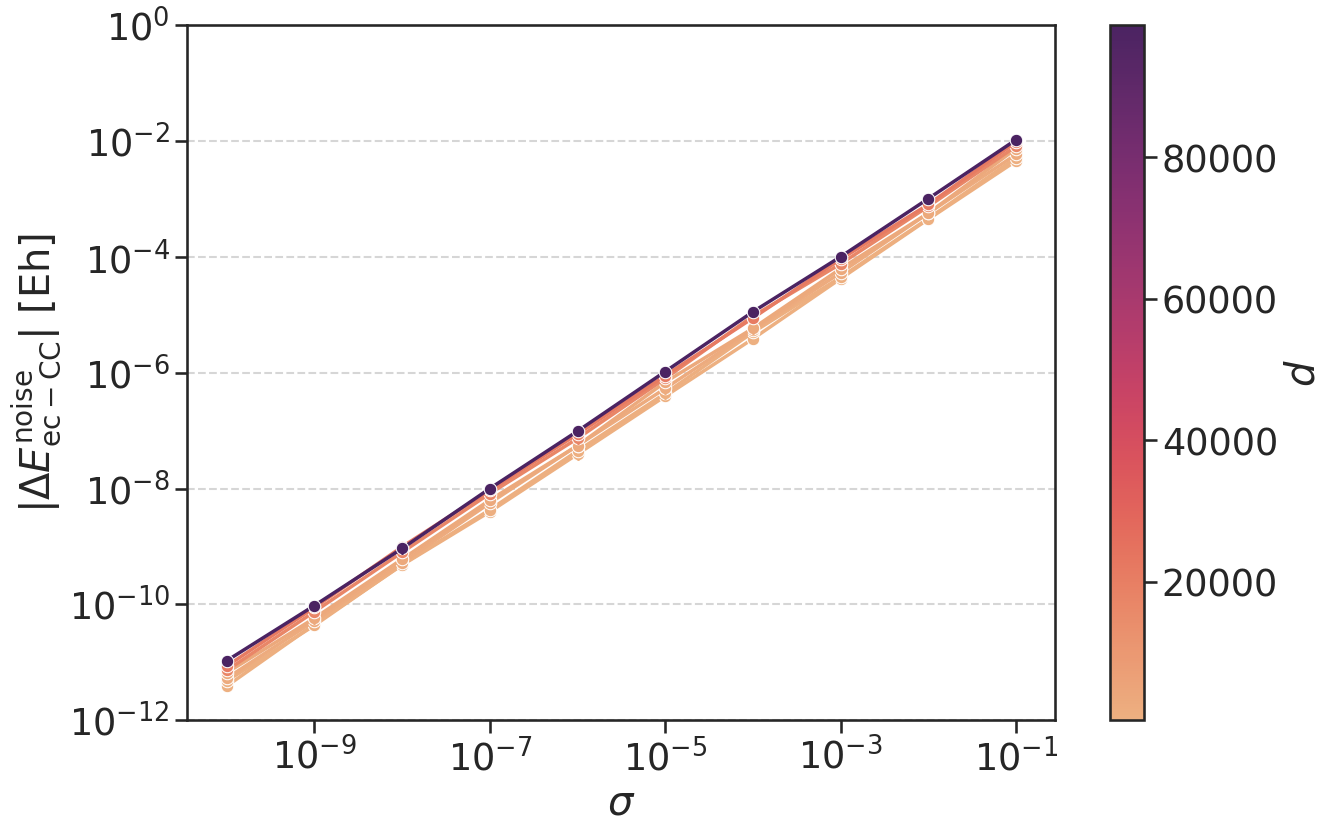

In [38]:
import matplotlib as mpl
import matplotlib.colors as colors
sns.set_theme(context="talk", font_scale=1.6, style="ticks")
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14, 9)
sns.lineplot(
    ax=ax, data=merged_df, x="std", y="tcc_error", hue="noverlaps",
    markers=True, err_style="bars", marker="o", linewidth=2.5,
    palette="flare",
    # legend="full",
    # legend="brief",
    # hue_norm=mpl.colors.LogNorm()
)
ax.set_yscale("log")
ax.set_xscale("log")
# ax.set_xlabel(r"$\sigma_\mathrm{noise}$")
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"$|\Delta E^\mathrm{noise}_\mathrm{ec-CC}|$ [Eh]")

ax.get_legend().remove()

sm = plt.cm.ScalarMappable(
    cmap="flare",
    # norm=colors.LogNorm(vmin=merged_df['noverlaps'].min(), vmax=merged_df['noverlaps'].max()),
    norm=colors.Normalize(vmin=merged_df['noverlaps'].min(), vmax=merged_df['noverlaps'].max()),
)
# sm.set_array([])
ax.figure.colorbar(
    sm, ax=ax,
    # extend="max",
    label=r"$d$"
)
ax.set_ylim(1e-12, 1e-0)
ax.yaxis.grid(True, linestyle="--", alpha=0.8)

# import matplotlib.ticker as ticker
# handles, labels = ax.get_legend_handles_labels()
# formatter = ticker.ScalarFormatter(useMathText=True)
# formatter.set_powerlimits((1, 5))
# labels = [f"${formatter.format_data(int(label))}$" for label in labels]

# linewidth = 4.0
# for handle in handles:
#     handle.set_linewidth(linewidth)

# Create a new legend with the updated labels
# ax.legend(handles, labels, title=r"$n_\mathrm{overlap}$")
plt.tight_layout()
plt.savefig("noise_eccc_colorbar.png", dpi=300)
plt.savefig("noise_eccc_colorbar.pdf", dpi=300)

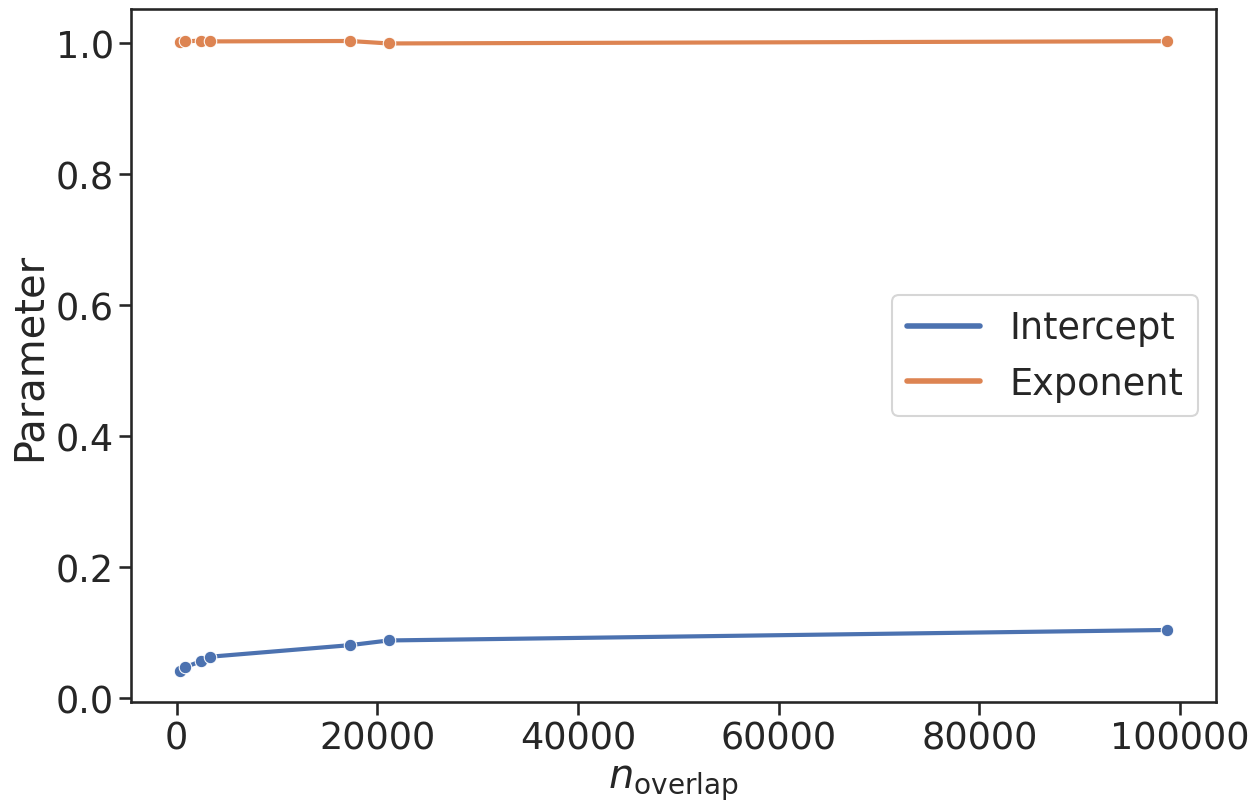

In [31]:
# ax = sns.lineplot(data=data, x="noverlaps", y="a", marker="o")
# ax.set_xscale('log')
# ax.set_yscale('log')
dfm = pd.melt(data, id_vars="noverlaps", value_vars=["a", "b"], value_name="parameter", var_name="fit")

sns.set_theme(context="talk", font_scale=1.6, style="ticks")
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14, 9)
sns.lineplot(
    ax=ax,
    data=dfm, x="noverlaps", y="parameter", hue="fit",
    markers=True,
    marker="o",
    linewidth=3,
    # palette="flare",
    # legend="full",
    # hue_norm=mpl.colors.LogNorm()
)
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlabel(r"$n_\mathrm{overlap}$")
ax.set_ylabel("Parameter")

handles, labels = ax.get_legend_handles_labels()
linewidth = 4.0
for handle in handles:
    handle.set_linewidth(linewidth)

labels = ["Intercept", "Exponent"]
# Create a new legend with the updated labels
ax.legend(handles, labels, title="")

/fs/home/cvsik/miniforge3/envs/tcc/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                                 OLS Regression Results                                
Dep. Variable:                      a   R-squared (uncentered):                   0.735
Model:                            OLS   Adj. R-squared (uncentered):              0.715
Method:                 Least Squares   F-statistic:                              36.07
Date:                Fri, 28 Jul 2023   Prob (F-statistic):                    4.40e-05
Time:                        11:42:30   Log-Likelihood:                         -8.0060
No. Observations:                  14   AIC:                                      18.01
Df Residuals:                      13   BIC:                                      18.65
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

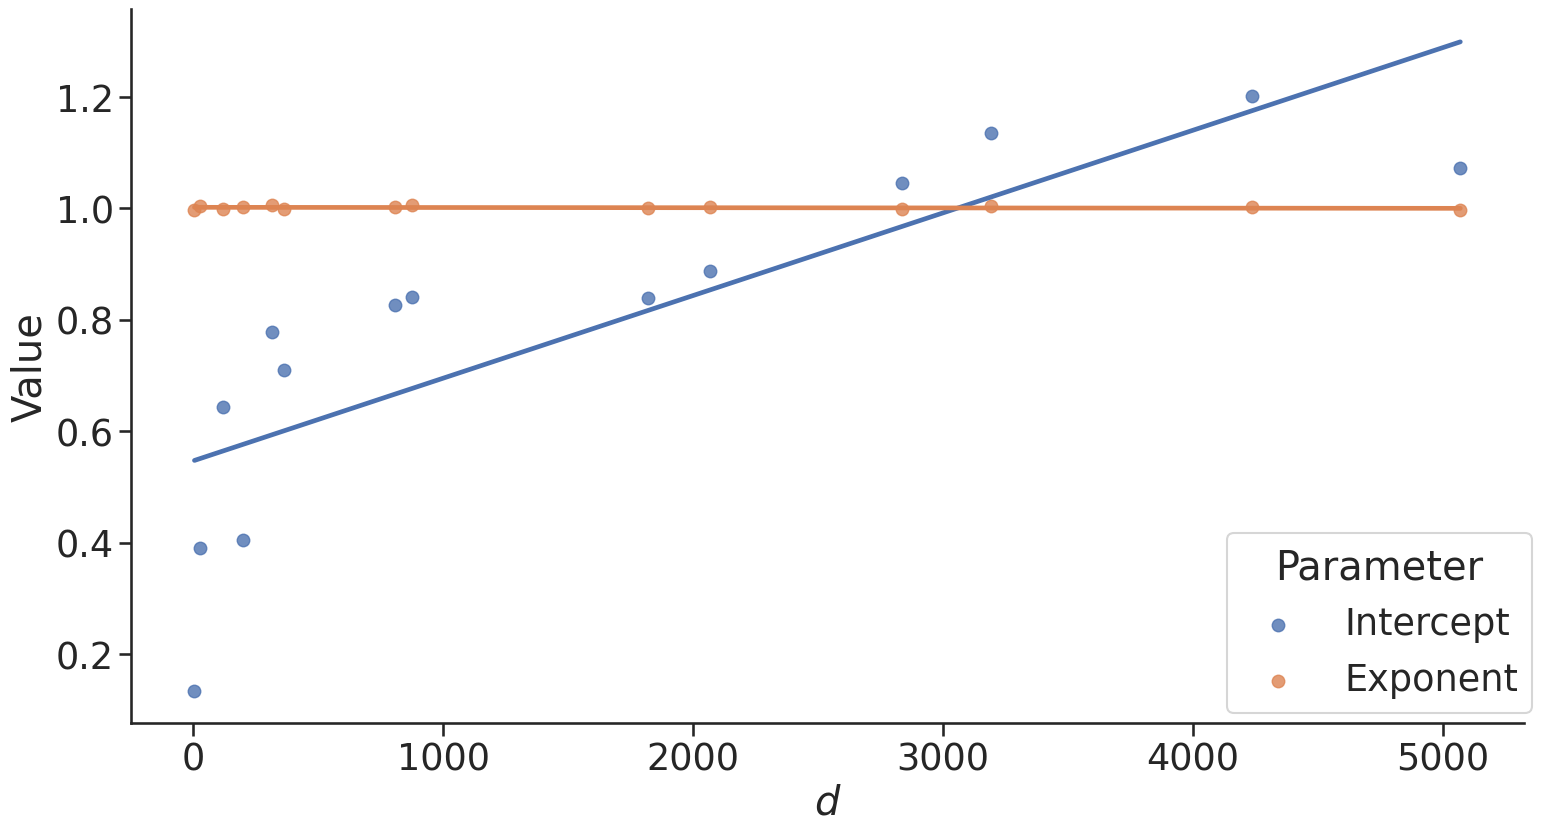

In [8]:
g = sns.lmplot(
    data=dfm,
    x="noverlaps", y="parameter", hue="fit",
    height=9,
    # robust=True,
    ci=None,
)

import statsmodels.api as sm

X = data.noverlaps
# X = sm.add_constant(X)
model = sm.OLS(data.a, X)
results = model.fit()
print(results.summary())

# Use more informative axis labels than are provided by default
g.set_axis_labels(r"$d$", "Value")
g.legend.texts[0].set_text("Intercept")
g.legend.texts[1].set_text("Exponent")
g.fig.set_size_inches(16, 9)
sns.move_legend(g, "lower right", bbox_to_anchor=(0.99, 0.15), title="Parameter", frameon=True, ncol=1)
plt.tight_layout()
# plt.savefig("powerlaw_fit_trend.png", dpi=300)